In [1]:
import string
import re
import random
import sqlite3
import json

import pandas as pd
import openpyxl
import numpy as np
from matplotlib import pyplot as plt

from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer,Interpreter,Metadata
from rasa_nlu import config

from iexfinance.stocks import Stock

加载预训练的意图识别模型

In [2]:
interpreter=Interpreter.load('Proj-model')

C:\Users\liuyi\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.20.4. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\liuyi\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.20.3 when using version 0.20.4. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\liuyi\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.3 when using version 0.20.4. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


格式化回答

In [3]:
rules = {'I wanna (.*)': ['What would it mean if you got {0}', 
                         'Why do you want {0}', 
                         "What's stopping you from getting {0}"], 
         'do you remember (.*)': ['Did you think I would forget {0}', 
                                  "Why haven't you been able to forget {0}"
                                 ], 
         'do you understand (.*)': ["How could I not understand {0} ;)"], 
         'do you think (.*)': ['if {0}? Absolutely.'], 
         'if (.*)': ["Do you really think it's likely that {0}", 
                     'Do you wish that {0}', 
                     'What do you think about {0}', 
                     'Really--if {0}'],
         'Im (.*)': ["hello {0}"
                     ],
         'my name is (.*)': ["hello {0}"
                 ]
         }

def match_rule(rules, message):
    for pattern, responses in rules.items():
        match = re.search(pattern, message)
        if match is not None:
            response = random.choice(responses)
            var = match.group(1) if '{0}' in response else None
            return response, var
    return "default", None

代词替换

In [4]:
def replace_pronouns(message):
    message = message.lower()
    if "you're" in message:
        message = re.sub("'re", " #are#", message)
    if "you are" in message:
        message = re.sub("are", "#are#", message)
    if "i'm" in message:
        message = re.sub("'m", ' #am#', message)
    if "i am" in message:
        message = re.sub("am", '#am#', message)

    if ' you ' in message:
        message = re.sub('you', '#you#', message)
    if ' me ' in message:
        message = re.sub('me', '#me#', message)
    if ' i ' in message:        
        message = re.sub(' i ', ' #i# ', message)    
    if ' my ' in message:
        message = re.sub('my', '#my#', message)
    if ' your ' in message:
        message = re.sub('your', '#your#', message)
        
    message = re.sub("#you# #are#", "i am", message)
    message = re.sub("#you#", "me", message)
    message = re.sub("#i# #am#", 'you are', message)
    message = re.sub("#i#", 'you', message)
    message = re.sub("#me#", 'you', message)
    message = re.sub('#my#','your', message)
    message = re.sub('#your#','my', message)

    return message

意图匹配

In [5]:
keywords = {
            'greet': [' hello ', ' hi ', ' hey '], 
            'thankyou': ['thank', 'thx'], 
            'goodbye': ['bye', 'farewell','that is all','ok,thanks'],
            'year':['age','How old are you','how old are you'],
            'func':['function','what can you do', 'What can you do for me','can you do'],
            'name':['your name','who are you','Who are you', 'call you', 'are you called'],    
    
            'number':['0','1','2','3','4','5','6','7','8','9'],
            'hprice':['history price'],
            'form':['sheet','text'],

            'high': ['high'],
            'low': ['low'],

            'volume':['volume'],
            'open':['open price'],
            'close':['close price'],

            'changepercent':['changepercent'],
            'trend':['trend']            
           }
patterns={}
# Iterate over the keywords dictionary
for intent, keys in keywords.items():
    # Create regular expressions and compile them into pattern objects
    patterns[intent] = re.compile("|".join(keys))

def match_intent(message, interpreter):
    matched_intent = None
    for intent, pattern in patterns.items():
        # Check if the pattern occurs in the message 
        if re.search(pattern,message):
            matched_intent = intent
    if(matched_intent == None):
        matched_intent = interpreter.parse(message)["intent"]["name"]
    return matched_intent

SQL数据库查询

In [6]:
def find_stocks(params, excluded):
    query = 'SELECT * FROM stocklist'
    if len(params) > 0:
        filters = ["{}=?".format(k) for k in params] + ["name!='?'".format(k) for k in excluded] 
        query += " WHERE " + " and ".join(filters)
    t = tuple(params.values())
    
    # open connection to DB
    conn = sqlite3.connect('stocklist.db')
    # create a cursor
    c = conn.cursor()
    c.execute(query, t)
    return c.fetchall()

否定甄别与荐股

In [7]:
recommendation = ["I'm sorry :( I couldn't find anything like that", 
                  '{} is a great stock!', 
                  '{} or {} would work!', 
                  'what about {}, {} and {}?']

def respond(message, params, suggestions, excluded, interpreter):
    parse_data = interpreter.parse(message)
    
    if (' no '  in message) or (' not ' in message) or ("n't " in message):
        excluded.extend(suggestions)
        
    entities = parse_data["entities"]    
    for ent in entities:
        params[ent["entity"]] = str(ent["value"])
        
    results = [
        r 
        for r in find_stocks(params, excluded) 
        if r[0] not in excluded
    ]
    
    names = [r[0] for r in results]
    n = min(len(results), 3)
    suggestions = names[:n]
    return recommendation[n].format(*names), params, suggestions, excluded

整合前述模块，完成聊天及单轮查询部分

In [8]:
responses = {'greet': 'Hello you! :)', 
             'thankyou': 'You are very welcome', 
             'goodbye': 'have a nice day!',
             'year': 'I was born long long ago :)',
             'func': 'I can help you check stocks :)',
             'name': 'I am STOCK-CHECKING-BOT! I can help you check stocks :)',
             'default': 'I do not understand :( sorry'
            }

def intent_response(message, params, suggestions, excluded, interpreter):
    intent = match_intent(message, interpreter)    
    key = "default"
    if intent in responses:
        key = intent
        return responses[key], {}, [], []
    else:
        return respond(message, params, suggestions, excluded, interpreter)
    
def chitchat_response(message, interpreter):
    global params, suggestions, excluded
    response, phrase = match_rule(rules, message)
    
    if response == "default":
        intent = match_intent(message,interpreter)
        key = "default"
        if intent in responses:
            key = intent
            return responses[key]
        else:
            return None
    
    if '{0}' in response:
        phrase = replace_pronouns(phrase)
        response = response.format(phrase)
        return response
    
    response, params, suggestions, excluded = intent_response(message, params, suggestions, excluded, interpreter)
    return response

多轮查询状态机

In [9]:
INIT=0
HP=1
OP=2
PP=3

# 查询操作中的状态转换，多轮查询
policy_rules = {
    (INIT, "location"): (INIT, "What kind of stock do you want to check?", None),
    
    (INIT, "hprice"): (INIT, "In which kind of format do you prefer the result to be shown? Sheet or text?", HP),
    (HP, "hprice"): (INIT, None, None),

    (INIT, "trend"): (INIT, "Please choose a specific thing so that I can help you to check it out.", PP),
    (PP, "trend"): (INIT, None, None),    
    
    (INIT, "high"): (PP, "OK, I'm looking for the high price. This might take a few second...", None),
    (INIT, "low"): (PP, "OK, I'm looking for the low price. This might take a few second...", None),
    (INIT, "form"): (HP, "OK, I'm looking for the form. This might take a few second...", None),
    
    (INIT, "close"): (INIT, "Please enter the date that you want to check.", OP),
    (INIT, "volume"): (INIT, "Please enter the date that you want to check.", OP),
    (INIT, "open"): (INIT, "Please enter the date that you want to check.", OP),
    (INIT, "number"): (OP, "OK, I'm looking for the data. This might take a few second...", None),
    
    (OP, "open"): (INIT, None, None),
    (OP, "close"): (INIT, None, None),
    (OP, "volume"): (INIT, None, None)
}

def policy_response(state, pending, message,interpreter):
    global params, suggestions, excluded
    global stockname
    global CHECK
    try:
        new_state, response, pending_state = policy_rules[(state, match_intent(message,interpreter))]
    except KeyError:
        reply_to_user("Sorry, I don't quite unerstand. :(")
        return state,pending
    else:
        if(response is not None):
            reply_to_user(response)
        if pending is not None:
            new_state, response, pending_state = policy_rules[pending]
            if(response is not None):
                reply_to_user(response)
        if pending_state is not None:
            pending = (pending_state, match_intent(message,interpreter))
        return new_state, pending

iexfinance API 接口调用

In [10]:
def get_book(ID):
    appl = Stock(ID,token = "pk_05a3d93860d54ae4a2c0f9a01ed362d5")
    x=appl.get_book()
    return x

def get_historical_prices(ID):
    appl = Stock(ID,token = "pk_05a3d93860d54ae4a2c0f9a01ed362d5")
    x=appl.get_historical_prices()
    return x

def get_previous_day_prices(ID):
    appl = Stock(ID,token = "pk_05a3d93860d54ae4a2c0f9a01ed362d5")
    x=appl.get_previous_day_prices()
    return x

图表生成模块

In [11]:
def text2pic(ID,json_str):
    y=[]
    x=np.arange(0,len(json_str))
    filename='res.jpg'
    for list_mem in json_str:
        #print(list_mem[ID])
        #print(type(list_mem[ID]))
        y.append(list_mem[ID])
    firstdate=json_str[0]["date"]
    plt.title("stock trends")
    plt.xlabel("0 means "+firstdate)
    plt.ylabel(ID)
    print(x)
    print(y)
    plt.plot(x, y)
    plt.savefig(filename)
    return filename

def text2sheet(json_str):
    with open('temp.txt','w', encoding = 'UTF-8') as fr:
         for list_mem in json_str:
             list_mem=str(list_mem)
             list_mem=list_mem.replace("'", '"')
             fr.write('['+list_mem+']'+"\n")
    
    data = []
    with open('temp.txt','r', encoding = 'UTF-8') as fr:
        for line in fr:
            j = json.loads(line)
            data.append(j)
    
    df = pd.DataFrame()
    for line in data:
        for i in line:
            df1 = pd.DataFrame([i])
            df = df.append(df1)
    
    df.to_excel('data.xlsx', sheet_name='Data', startcol=0, index=False)
    
def checksheet(date,item):
    wb=openpyxl.load_workbook('data.xlsx')
    ws=wb.active
    x=''
    y=''
    flag1,flag2=0,0
    
    for i in range(ord("A"),ord("O")+1):
        if(ws[chr(i)+'1'].value==item):
            x=chr(i)
            flag1=1
            break
    for j in range(1,22):
        if(ws['E'+str(j)].value==date):
            y=str(j)
            flag2=1
            break
    if(flag1==1 and flag2==1):
        return ws[x+y].value
    else:
        return None
    
def date_extract(message):
    x = re.compile(r'\d{4}-\d{2}-\d{2}')
    date=x.findall(message)
    return date

整合前述模块，组成完整应答机

In [12]:
def stock_choosed():
    global stockname
    if (stockname == ''):
        response = "you have to choose a stock first."
        reply_to_user(response)
        return 0
    return 1

def send_message(state, pending, message, interpreter):
    global params, suggestions, excluded
    global stockname
    global date,item
    global sheet_flag,pic_flag
    
    response = chitchat_response(message,interpreter)
    
    if response is not None:
        reply_to_user(response)
        return state, None
    
    intent = match_intent(message,interpreter)
    
    if ('search' in intent) or ('location' in intent) or ('affirm' in intent) or ('deny' in intent):
        response, params, suggestions, excluded = intent_response(message, params, suggestions, excluded,interpreter)
        reply_to_user(response)
        return state, None

    elif ('hprice' in intent) or ("form" in intent):
        if (stock_choosed() == 0):
            return state, None
        else:
            new_state,pending = policy_response(state, pending, message,interpreter)
            if(intent=='hprice'):
                return new_state,pending
            else:
                if("text" in message):
                   response=str(get_historical_prices(stockname))
                   reply_to_user(response)
                else:
                    text2sheet(get_historical_prices(stockname))
                    sheet_flag=1
                return new_state,pending

    elif ('trend' in intent) or ('high' in intent) or ('low' in intent):
        if (stock_choosed() == 0):
            return state, None
        else:
            new_state, pending = policy_response(state, pending, message, interpreter)
            if('trend' in intent):
                return new_state, pending
            else:
                text2pic(intent,get_historical_prices(stockname))
                pic_flag=1
                return new_state, pending

    elif (intent=='open') or (intent=='close') or (intent=='volume') or (intent=='number'):
        if (stock_choosed() == 0):
            return state, None
        else:
            new_state,pending = policy_response(state, pending, message,interpreter)
            if (intent != 'number'):
                item = intent
            else:
                date = date_extract(message)[0]
            if (item != '' and date != ''):
                text2sheet(get_historical_prices(stockname))
                response = checksheet(date,item)
                if(response is not None):
                    reply_to_user(response)
                    item=''
                    date=''
                else:
                    response="Sorry, I can't find what you want."
                    reply_to_user(response)
                    item = ''
                    date = ''
            return new_state,pending

    elif ('sp_stock' in intent):
        stockname = interpreter.parse(message)["entities"][0]["value"]
        response = ("I see, you'd like to check {0}. And?".format(stockname))
        reply_to_user(response)
        return state, None

    else: 
        response = "Sorry, I don't understand :("
        reply_to_user(response)
        return state, None

In [13]:
def reply_to_user(response):
    global reply
    print("BOT : {}".format(response))
    reply.append(response)

USER: hi there
BOT : Hello you! :)
USER: my name is Allen!
BOT : hello allen!
USER: do you remember when I last came here? 
BOT : Why haven't you been able to forget when you last came here? 
USER: what can you do
BOT : I can help you check stocks :)
USER: do you understand what i'm talking about?
BOT : How could I not understand what you are talking about? ;)
USER: some stocks in US please
BOT : what about PEP, BAC and SBUX?
USER: hmmm...I don't like these. gimme something else.
BOT : what about KO, GE and AAPL?
USER: AAPL please
BOT : I see, you'd like to check aapl. And?
USER: so show me the high price
BOT : OK, I'm looking for the high price. This might take a few second...
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[113.28, 116.04, 115, 116.09, 116, 117.16, 118.39, 124.87, 128.79, 125.18, 126.99, 127.49, 126.44, 131, 134.8, 137.98, 128.84, 123.7, 118.99, 119.14, 120.5, 115.23]


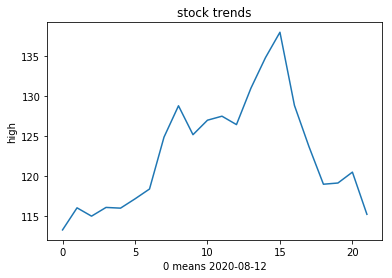

In [14]:
params, suggestions, excluded = {}, [], []

stockname=''
item=''
date=''

reply=[]
state = INIT
pending = None

#发送表格位
sheet_flag=0
#发送图片位
pic_flag=0

for message in ["hi there",
                "my name is Allen!",
                "do you remember when I last came here? ",
                "what can you do",
                "do you understand what i'm talking about?",
                "some stocks in US please",
                "hmmm...I don't like these. gimme something else.",
                "AAPL please",
                "so show me the high price"
               ]:
    print("USER: {}".format(message))
    state, pending = send_message(state, pending, message, interpreter)

USER: do you think humans should be worried about AI
BOT : if humans should be worried about ai? Absolutely.
USER: how old are you
BOT : I was born long long ago :)
USER: BIDU
BOT : I see, you'd like to check bidu. And?
USER: show me the open price of it
BOT : Please enter the date that you want to check.
USER: close price, please
BOT : Please enter the date that you want to check.
USER: 2022-05-06
BOT : OK, I'm looking for the data. This might take a few second...
BOT : Sorry, I can't find what you want.
USER: 2019-07-19
BOT : OK, I'm looking for the data. This might take a few second...
USER: AAPL
BOT : I see, you'd like to check aapl. And?
USER: show me the trend
BOT : Please choose a specific thing so that I can help you to check it out.
USER: low price
BOT : OK, I'm looking for the low price. This might take a few second...
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[110.3, 113.93, 113.05, 113.96, 114.01, 115.61, 115.73, 119.25, 123.94, 123.05, 125.08, 123

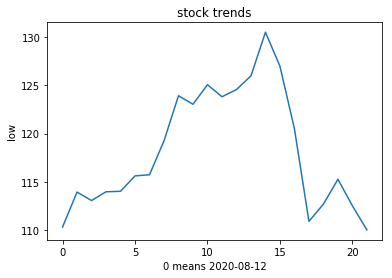

In [15]:
stockname=''
item=''
date=''

reply=[]
state = INIT
pending = None

for message in ["do you think humans should be worried about AI",
                "how old are you",
                "BIDU",
                "show me the open price of it",
                "close price, please",
                "2022-05-06",
                "2019-07-19",
                "AAPL",
                "show me the trend",
                "low price",
                "bye"
               ]:
    print("USER: {}".format(message))
    state, pending = send_message(state, pending, message, interpreter)